In [6]:
import pandas as pd
import torch
from transformers import BertModel, BertTokenizer

**Data:** `df_cleaned`
* English
* emoji removed
* 10-core
* No duplicates
Count: 179,590

In [8]:
df_cleaned = pd.read_csv("data/df_cleaned_w_na.csv")

df_cleaned.drop_duplicates(inplace=True)

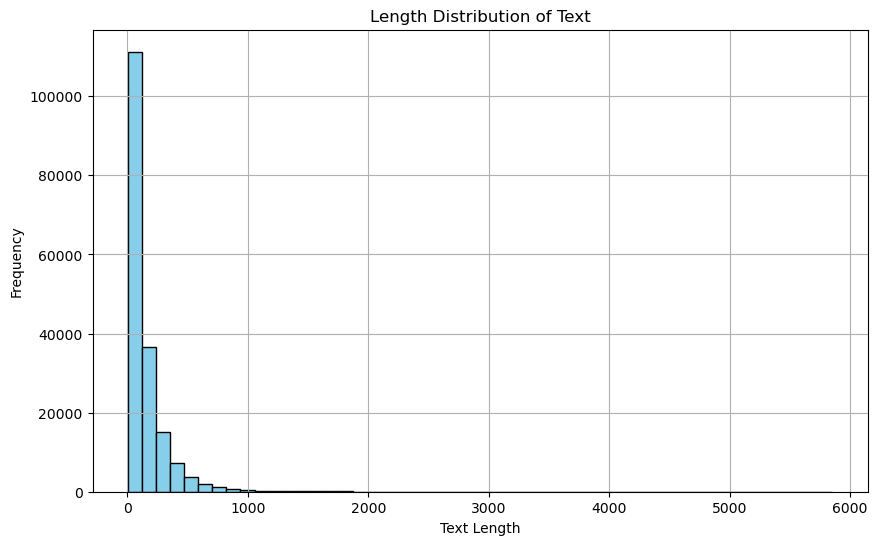

In [9]:
import matplotlib.pyplot as plt

# Calculate the length of each text
text_lengths = df_cleaned['text'].apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Length Distribution of Text')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
comments_longer_than_100 = df_cleaned[df_cleaned['text'].str.len() > 512]

# Calculate the percentage of comments longer than 100 characters
percentage_longer_than_100 = (len(comments_longer_than_100) / len(df_cleaned)) * 100

print(f"Percentage of comments longer than 512 characters: {percentage_longer_than_100:.2f}%")


Percentage of comments longer than 512 characters: 4.32%


## BERT

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [5]:
def generate_embedding(input_text):
    # Tokenize input text
    input_ids = tokenizer.encode_plus(input_text, 
                                      add_special_tokens=True, 
                                      return_tensors="pt", 
                                      truncation=True,
                                      max_length=512)  # Adjust max_length
    with torch.no_grad():
        outputs = model(**input_ids)  # Pass the tokenized inputs as keyword arguments
        embeddings = outputs.last_hidden_state  # Extract the embeddings
    return embeddings

In [ ]:
df_cleaned['bert_embeddings'] = df_cleaned['text'].apply(generate_embedding)

In [ ]:
df_cleaned.to_csv("data/df_cleaned_w_na.csv", index=False)